<div style="text-align: left;">
<table style="width:100%; background-color:transparent;">
  <tr style="background-color:transparent;">
    <td style="background-color:transparent;"><img src="https://baobablab.github.io/bhb/images/collaborators/upsaclay.png" width="40%"></td>
    <td style="background-color:transparent;"><img src="https://baobablab.github.io/bhb/images/collaborators/cea.jpg" width="30%"></td>
  </tr>
</table> 
</div>

<center><h1>OpenBHB challenge: predicting brain age with site-effect removal</h1></center>

<center><h3>A data challenge on Healthy Controls</h3></center>


**To download and run this notebook**: download the [full starting kit](https://github.com/ramp-kits/brain_age_with_site_removal), with all the necessary files.

## Software

This starting kit requires Python 3 and the following dependencies:

* `numpy`
* `scipy`
* `nibabel`
* `pandas`
* `scikit-learn`
* `nilearn`
* `matplolib`
* `seaborn`
* `jupyter`
* `progressbar`
* `torch`
* `ramp-workflow`

You can install the dependencies using `pip` with the following command-line:

```
pip install -U -r requirements.txt
```

If you are using `conda`, we provide an `environment.yml` file for similar usage:

```
conda env create -n ramp-brainage-siterm -f environment.yml
```

Then, you can activate/desactivate the conda environment using:

```
conda activate ramp-brainage-siterm
conda deactivate
```

## Introduction: what is this challenge about

Modelling brain development and maturation in the healthy population with Machine Learning (ML) from brain MRI images is a fundamental challenge. Biological processes implied are complex and highly heterogeneous between individuals, comprising both environmental and genetic variability across subjects. As a result, there is a need for large MRI datasets including subjects with a wide range of age. However, these datasets are often multi-sites (i.e images are acquired at different hospitals or acquisition centers across the world) and it induces a strong bias in current MRI data, due to difference between scanners (magnetic field, constructor, gradients, etc.)

Consequently, this challenge aims at building i) robust ML models that can accuratly predict chronological age from brain MRI while ii) removing non-biological site information from MRI images. We have designed this challenge in the context of **representation learning** and it promotes the development of new ML and **Deep Learning** algorithms.

More specifically, aging is associated with grey matter (GM) atrophy. Each year, an adult lose 0.1% of GM. We will try to learn a predictor of the chronological age (true age) using GM derived features on a population of healthy control participants.

Such a predictor provides the expected **brain age** of a subject. Deviation from this expected brain age indicates acceleration or slowdown of the aging process which may be associated with a pathological neurobiological process or protective factor of aging.

The dataset is composed of images coming from various sites, different MRI scanners and acquired under various settings. In order to predict properly the age of participants, one should deal with the **site/scanner effect**.

**Objective:** the models submitted to this challenge must encode the data (i.e. perform dimensionality reduction) such that all biological age features are retained while scanner/acquisition protocol information are removed from the resulting encoded data.

## The data

We propose to use the [openBHB dataset](https://baobablab.github.io/bhb/dataset). This dataset is composed of 3227 training images, 757 validation images (available from command line with `download_data.py` or from [IEEE Dataport](https://ieee-dataport.org/open-access/openbhb-multi-site-brain-mri-dataset-age-prediction-and-debiasing)) and 664 testing images (kept private). The validation set is composed of 2 subsets: an internal set (with images acquired from the same MRI scanners as training images); and an external set (with images acquired with different scanners/protocols as training images). It is used for local testing/debugging (e.g. using `ramp-test`, see below) or for cross-validating hyper-parameters of your model.

### Input data

All data have been preprocessed uniformly and checked. The dataset is composed of T1w images derived features composed of Quasi-Raw, CAT12 VBM, and FreeSurfer:

- Quasi-Raw: minimally preprocessed data were generated using [ANTS bias field correction](https://manpages.debian.org/testing/ants/N4BiasFieldCorrection.1.en.html), [FSL FLIRT](https://fsl.fmrib.ox.ac.uk/fsl/fslwiki/FLIRT) affine registration with 9 degrees of freedom (no shearing) to the isotropic 1mm MNI template, and the application of a brain mask to remove non-brain tissues in the final images.

- CAT12 VBM: Voxel-Based Morphometry (VBM) was performed with [CAT12](http://www.neuro.uni-jena.de/cat). The analysis stream includes non-linear spatial registration to the isotropic 1.5mm MNI template, Gray Matter (GM), White Matter (WM), and CerebroSpinal Fluid (CSF) tissues segmentation, bias correction of intensity non-uniformities, and segmentations modulation by scaling with the amount of volume changes due to spatial registration. VBM is most often applied to investigate the GM. The sensitivity of VBM in the WM is low, and usually, diffusion-weighted imaging is preferred for that purpose. For this reason, only the modulated GM images are shared. Moreover, CAT12 computes GM volumes averaged on the Neuromorphometrics atlas that includes 284 brain cortical and sub-cortical ROIs.

- FreeSurfer: Cortical analysis was performed with [FreeSurfer "recon-all"](https://surfer.nmr.mgh.harvard.edu). The analysis stream includes intensity normalization, skull stripping, segmentation of GM (pial) and WM, hemispheric-based tessellations, topology corrections and inflation, and registration to the **fsaverage** template. From the available morphological measures, the Desikan (68 regions) and Destrieux (148 regions) ROI-based surface area, GM volume, average thickness, thickness standard deviation, integrated rectified mean curvature, integrated rectified gaussian curvature, and intrinsic curvature are computed. The desikan parcellation, the cortical curvature, sulcal indices, and thickness are also available on a ico7 left/right symmetrized mesh with (163842 vertives) derived using FreeSurfer-Xhemi.

The `problem.get_[train|test]_data()` function returns a big matrix of shape $n_{subjects}\times n_{features}$. The features are the concatenation of all modalities: CAT12 VBM (519945 features), Quasi-Raw (1827095 features), FreeSurfer-Xhemi 4 x 2 (left and right hemispheres) channels | 163842 vertices (ico7), CAT12 VBM 284 ROIs (284 features), FreeSurfer Desikan 7 channels | 68 ROIs (476 features), and FreeSurfer 7 channels | 148 ROIs (1036 features)  data leading to a $n_{subjects} \times 3659572$ array. For ROI-based data, the channel and ROI dimensions has been flattened, and for image-based data a GM (for CAT12 VBM) or brain (for Quasi-Raw) mask has been applied using `nilearn.masking.apply_mask`.

A `FeatureExtractor` class is proposed in the `submissions/starting_kit/estimator.py` file that simplify the access of each data bloc. Below you will find some use cases of this functionality:

In [1]:
import os
import sys
import numpy as np
sys.path.append(os.path.realpath("submissions/starting_kit"))
from estimator import FeatureExtractor

# Need to specify where to find the brain and GM masks using env variables.
os.environ["VBM_MASK"] = "./cat12vbm_space-MNI152_desc-gm_TPM.nii.gz"
os.environ["QUASIRAW_MASK"] = "./quasiraw_space-MNI152_desc-brain_T1w.nii.gz"

X_flat = np.zeros((1, 2512678), dtype=np.single)
X = FeatureExtractor(dtype="vbm").transform(X_flat)
print("Shape of selected features", X.shape)

Shape of selected features (1, 1, 121, 145, 121)


**Remark:** `problem.get_test_data()` returns locally (on your computer) the official validation set for this challenge.

### Target labels

The `problem.get_[train|test]_data()` function returns as second element the target vector composed of `age` and `site` information.

Read TRAIN...
    age  site
0  19.0     0
1  21.0     1
2  21.0     2
3  15.0     4
4  31.0     1
               age
count  3227.000000
mean     25.189897
std      14.610795
min       6.000000
25%      19.000000
50%      21.000000
75%      26.000000
max      86.198494
Shape of data & selected features: (3227, 3659572) (10, 1, 121, 145, 121)
  channels
0       GM
Shape of data & selected features: (3227, 3659572) (10, 1, 182, 218, 182)
  channels
0      T1w
Shape of data & selected features: (3227, 3659572) (10, 8, 163842)
         channels
0  lh.aparc.annot
1         lh.curv
2         lh.sulc
3    lh.thickness
4  rh.aparc.annot
5         rh.curv
6         rh.sulc
7    rh.thickness

Dataset created in /tmp/tmpgo_hw0tw/fsaverage

 ...done. (3 seconds, 0 min)
Extracting data from /tmp/tmpgo_hw0tw/fsaverage/5592d63c5c8039b4f902396c128dcd85/download..... done.


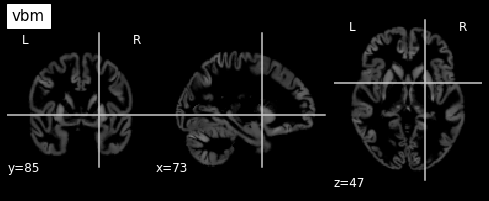

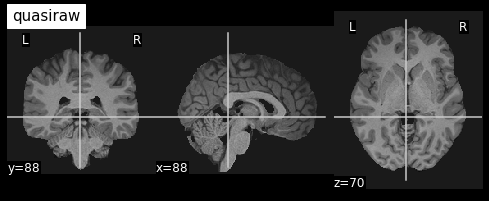

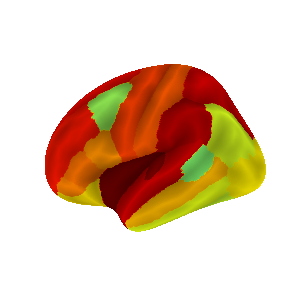

In [2]:
%matplotlib inline
from problem import get_train_data, DatasetHelper

train_dataset = DatasetHelper(data_loader=get_train_data)
X_train, y_train = train_dataset.get_data()
df_labels_train = train_dataset.labels_to_dataframe()
print(df_labels_train.head())
print(df_labels_train.describe(include=(float, )))
for dtype in ("vbm", "quasiraw", "xhemi"):
    X_select_train = FeatureExtractor(dtype=dtype).transform(X_train[:10])
    print("Shape of data & selected features:", X_train.shape,
          X_select_train.shape)
    print(train_dataset.get_channels_info(X_select_train))
    train_dataset.plot_data(X_select_train, sample_id=0, channel_id=0)

### Challenge Ranking and Evaluation metrics

In the context of representation learning, we perform **linear probing** to evaluate a model submitted on RAMP. Specifically, on the RAMP server, the public data-sets (training+validation) and private testing data (including internal and external subsets, see above) are encoded by the trained model, i.e all data are passed through the model. The resulting output vectors are stacked to build 3 matrices: $X_{train}\in \mathbb{R}^{n_{train}\times p}$ (public training+validation sets encoded), $X_{test}^{int}\in \mathbb{R}^{n_{test}\times p}$ (private internal test encoded), $X_{test}^{ext}\in \mathbb{R}^{n_{test}'\times p}$ (private external test encoded). $p<10^4$ is the model's output dimension (a.k.a latent space dimension). Both training+validation and *internal* test are stratified on both age, sex and **site** (i.e they contain the same sites with similar age and sex distributions). However, the *external* test contains acquisition **sites independent**from the public data-sets.

*Note:* we usually call $X_{train}, X_{test}^{int}, X_{test}^{ext}$ the model **representation**

After encoding, a simple linear Ridge regression is trained on $X_{train}$ and tested on $X_{test}^{int}$ and $X_{test}^{int}$ to predict age. The final Mean Absolute Error (MAE, the lower the better) is computed as the reference metric for age prediction and 2 final scores are computed: MAE(internal), computed on $X_{test}^{int}$, and MAE(external), computed on $X_{test}^{ext}$. As for site prediction, a linear logistic regression is also trained on $X_{train}$ and tested on $X_{test}^{int}$, $X_{test}^{ext}$. The final Balanced Accuracy (BAcc) is computed and serves as reference score for site prediction. Bacc should be **equal to random chance** in this challenge, that is $1/n_{sites}=1/64\approx1.56\%$ because we want the representation $X_{train}$ to *remove* site information from MRI images.

All models are ranked according to a combination of the 3 metrics: MAE(internal), MAE(external) and Bacc(sites). The official leaderboard can be find [here](https://baobablab.github.io/bhb/challenges/age_prediction_with_site_removal).


## Submitting to the online challenge: [ramp.studio](http://ramp.studio)

### Online submission

Once you found a good model, you can submit them to [ramp.studio](http://www.ramp.studio) to enter the online challenge. First, if it is your first time using the RAMP platform, [sign up](http://www.ramp.studio/sign_up), otherwise [log in](http://www.ramp.studio/login). Then sign up to the event [brain_age_with_site_removal](http://www.ramp.studio/events/brain_age_with_site_removal). Sign up for the event. Both signups are controled by RAMP administrators, so there **can be a delay between asking for signup and being able to submit**.

Once your signup request is accepted, you can go to your [sandbox](http://www.ramp.studio/events/brain_age_with_site_removal/sandbox) and copy-paste or upload. You can also create a new starting-kit in the `submissions` folder containing these three files `estimator.py`, `weights.pth` and `metadata.pkl` and upload those file directly. You can check the starting-kit ([`estimator.py`](https://github.com/ramp-kits/brain_age_with_site_removal/submissions/starting_kit/estimator.py)) for an example. The submission is only tested on our backend in the similar way as `ramp_test_submission` does it locally. That is the reason why the weights of the trained model needs to be uploaded. Moreover extra info/data can be provided in the metadata pickle file. It may enable to restore the scaler used during the training. While your submission is waiting in the queue and being trained, you can find it in the "New submissions (pending training)" table in [my submissions](http://www.ramp.studio/events/brain_age_with_site_removal/my_submissions). Once it is trained, you get a mail, and your submission shows up on the [official leaderboard](https://baobablab.github.io/bhb/challenges/age_prediction_with_site_removal) that is refreshed everyday.
If there is an error (despite having tested your submission locally with `ramp-test`, see below), it will show up in the "Failed submissions" table in [my submissions](http://www.ramp.studio/events/brain_age_with_site_removal/my_submissions). You can click on the error to see part of the trace.

The data-set we use at the backend is usually different from what you find in the starting kit, so the score may be different.

### Local test and Debugging

Once you have cloned the Github repository <https://github.com/ramp-kits/brain_age_with_site_removal> you can test your model locally (on your computer) to debug and evaluate your model's performance.

Each submission needs to be in a new folder located in the `submissions` directory. For instance, to create a `linear_regression_rois` submission, you can copy the `starting_kit` with:

```
cp -r submissions/strating_kit submissions/linear_regression_rois
```

Now, you have the 3 mandatory files created for a new submission (`estimator.py`, `weights.pth`, `metadata.pkl`) inside `submissions/linear_regression_rois` that you can customize. In particular, `estimator.py` must contain a function `get_estimator()` that returns a scikit-learn Pipeline (with `fit()` and `predict()` implemented). Once you have customized your estimator, weights and metadata, you can perform a local test with:

```
ramp-test --submission linear_regression_rois [--quick-test]
```

**Warning:** the data need to be downloaded beforehand using `download_data.py` script. It can take some time and about 55GB of disk memory. If you only want to perform a quick check with random data, you can use the option `--quick-test`.

*Note:* model weights are expected in a file called `weights.pth` located in your submission folder `submissions/linear_regression_rois`. Extra information/data can also be loaded from `metadata.pkl` file using **read_pickle()** from Pandas library (it can be useful de define a standardizer).

## Where to start: a simple MLP

We give a quick example of how to train a simple Multi-Layers Perceptron (MLP) using PyTorch on one modality (cortical thickness with Desikan atlas). The model's weights can be saved to `weights.pth` and a new submission can be created following the steps described previously.

### Data downloading

We start by downloading the data from the internet using the following command-line:

```
python download_data.py
```

The train/validation data will be available in the `data` directory. This download step can be long. We also provide a way to create a small random dataset enabling the `--test` option of the script:

```
python download_data.py --test
```

In the rest of this notebook we will use this random dataset. We will train a MLP on the average cortical thickness (channel 2) defined from the Desikan parcellation:

In [3]:
import os
import sys
sys.path.append(os.path.realpath("submissions/starting_kit"))
import time
import json
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import sklearn.metrics as metrics
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate
from sklearn.base import BaseEstimator, TransformerMixin
from joblib.externals.loky.backend.context import get_context
from problem import get_train_data, get_test_data, get_cv, DatasetHelper
from estimator import FeatureExtractor

# TODO: we selected only few (20) subjects for deployment speedup.
os.environ["RAMP_BRAIN_AGE_SITERM_TEST"] = "on"
train_dataset = DatasetHelper(data_loader=get_train_data)
X_train, y_train = train_dataset.get_data()
X_train = X_train[:20]
y_train = y_train[:20]
X_select_train = FeatureExtractor(dtype="desikan_roi").transform(X_train)
print("Shape of data & selected features:", X_train.shape,
      X_select_train.shape)
print(train_dataset.get_channels_info(X_select_train))
df_data_train = train_dataset.data_to_dataframe(X_select_train, channel_id=2)
print(df_data_train)
X_train = X_select_train[:, 2]
y_train = y_train[:, 0]

# TODO: we selected only few (10) subjects for deployment speedup.
test_dataset = DatasetHelper(data_loader=get_test_data)
X_test, y_test = test_dataset.get_data(dtype="internal")
X_test = X_test[:10]
y_test = y_test[:10]
X_select_test = FeatureExtractor(dtype="desikan_roi").transform(X_test)
print(X_test.shape, X_select_test.shape)
X_test = X_select_test[:, 2]
y_test = y_test[:, 0]

Read TRAIN...
Shape of data & selected features: (20, 3659572) (20, 7, 68)
                                        channels
0                              surface_area_mm^2
1                        gray_matter_volume_mm^3
2                           average_thickness_mm
3                            thickness_stddev_mm
4      integrated_rectified_mean_curvature_mm^-1
5  integrated_rectified_gaussian_curvature_mm^-2
6                      intrinsic_curvature_index
    lh-bankssts  lh-caudalanteriorcingulate  lh-caudalmiddlefrontal  \
0         2.695                       2.367                   2.569   
1         2.516                       2.354                   2.706   
2         2.616                       2.348                   2.577   
3         2.697                       2.686                   2.651   
4         2.204                       2.322                   2.492   
5         2.357                       2.360                   2.726   
6         2.497                     

(10, 3659572) (10, 7, 68)


### Custom scores

Let's define here some utility functions to compute scores:

In [4]:
def cv_train_test_scores(rmse_cv_test, rmse_cv_train, r2_cv_test, r2_cv_train,
                         y_train, y_pred_train, y_test, y_pred_test):
    """ Compute CV score, train and test score from a cv grid search model.

    Parameters
    ----------
    rmse_cv_test : array
        Test rmse across CV folds.
    rmse_cv_train : array
        Train rmse across CV folds.
    r2_cv_test : array
        Test R2 across CV folds.
    r2_cv_train : array
        Train R2 across CV folds.
    y_train : array
        True train values.
    y_pred_train : array
        Predicted train values.
    y_test : array
        True test values.
    y_pred_test : array
        Predicted test values.

    Returns
    -------
    info : TYPE
        DataFrame(r2_cv, r2_train, mae_train, mse_train).
    """
    # CV scores
    rmse_cv_test_mean, rmse_cv_test_sd = (
        np.mean(rmse_cv_test), np.std(rmse_cv_test))
    rmse_cv_train_mean, rmse_cv_train_sd = (
        np.mean(rmse_cv_train), np.std(rmse_cv_train))

    r2_cv_test_mean, r2_cv_test_sd = (
        np.mean(r2_cv_test), np.std(r2_cv_test))
    r2_cv_train_mean, r2_cv_train_sd = (
        np.mean(r2_cv_train), np.std(r2_cv_train))

    # Test scores
    rmse_test = np.sqrt(metrics.mean_squared_error(y_test, y_pred_test))
    r2_test = metrics.r2_score(y_test, y_pred_test)

    # Train scores
    rmse_train = np.sqrt(metrics.mean_squared_error(y_train, y_pred_train))
    r2_train = metrics.r2_score(y_train, y_pred_train)

    scores = pd.DataFrame(
        [[rmse_cv_test_mean, rmse_cv_test_sd, rmse_cv_train_mean,
          rmse_cv_train_sd, r2_cv_test_mean, rmse_cv_test_sd, r2_cv_train_mean,
          r2_cv_train_sd, rmse_test, r2_test, rmse_train, r2_train]],
        columns=("rmse_cv_test_mean", "rmse_cv_test_sd", "rmse_cv_train_mean",
                 "rmse_cv_train_sd", "r2_cv_test_mean", "rmse_cv_test_sd",
                 "r2_cv_train_mean", "r2_cv_train_sd", "rmse_test", "r2_test",
                 "rmse_train", "r2_train"))

    return scores

### PyTorch model definition and training

Let's design a simple MLP age predictor. The framework is evaluated with a cross-validation approach. The metrics used are the root-mean-square error (RMSE).

In [5]:
class MLP(nn.Module):
    """ Define a simple one hidden layer MLP.
    """
    def __init__(self, in_features):
        super(MLP, self).__init__()
        self.layers = nn.Sequential(
          nn.Linear(in_features, 120),
          nn.ReLU(),
          nn.Linear(120, 84),
          nn.ReLU(),
          nn.Linear(84, 1))

    def forward(self, x):
        return self.layers(x)


class Dataset(torch.utils.data.Dataset):
    """ A torch dataset for regression.
    """
    def __init__(self, X, y=None):
        """ Init class.

        Parameters
        ----------
        X: array-like (n_samples, n_features)
            training data.
        y: array-like (n_samples, ), default None
            target values.
        """
        self.X = torch.from_numpy(X)
        if y is not None:
            self.y = torch.from_numpy(y)
        else:
            self.y = None

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        if self.y is not None:
            return self.X[i], self.y[i]
        else:
            return self.X[i]


class RegressionModel(object):
    """ Base class for Regression models.
    """
    def __init__(self, model, batch_size=5, n_epochs=3, print_freq=1):
        """ Init class.

        Parameters
        ----------
        model: nn.Module
            the input model.
        batch_size:int, default 10
            the mini_batch size.
        n_epochs: int, default 5
            the number of epochs.
        print_freq: int, default 100
            the print frequency.
        """
        self.model = model
        self.batch_size = batch_size
        self.n_epochs = n_epochs
        self.print_freq = print_freq

    def fit(self, X, y):
        """ Fit model.

        Parameters
        ----------
        X: array-like (n_samples, n_features)
            training data.
        y: array-like (n_samples, )
            target values.
        fold: int
            the fold index.
        """
        self.model.train()
        self.reset_weights()
        print("-- training model...")
        dataset = Dataset(X, y)
        loader = torch.utils.data.DataLoader(
            dataset, batch_size=self.batch_size, shuffle=True,
            num_workers=1, multiprocessing_context=get_context("loky"))
        loss_function = nn.L1Loss()
        optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-4)
        start_time = time.time()
        current_loss = 0.
        for epoch in range(self.n_epochs):
            for step, data in enumerate(loader, start=epoch * len(loader)):
                inputs, targets = data
                inputs, targets = inputs.float(), targets.float()
                targets = targets.reshape((targets.shape[0], 1))
                optimizer.zero_grad()
                outputs = self.model(inputs)
                loss = loss_function(outputs, targets)
                loss.backward()
                optimizer.step()
                current_loss += loss.item()
                if step % self.print_freq == 0:
                    stats = dict(epoch=epoch, step=step,
                                 lr=optimizer.param_groups[0]["lr"],
                                 loss=loss.item(),
                                 time=int(time.time() - start_time))
                    print(json.dumps(stats))
        current_loss /= (len(loader) * self.n_epochs)

    def predict(self, X):
        """ Predict using the input model.

        Parameters
        ----------
        X: array-like (n_samples, n_features)
            samples.

        Returns
        -------
        C: array (n_samples, )
            returns predicted values.
        """
        self.model.eval()
        dataset = Dataset(X)
        testloader = torch.utils.data.DataLoader(
            dataset, batch_size=self.batch_size, shuffle=False, num_workers=1,
            multiprocessing_context=get_context("loky"))
        with torch.no_grad():
            C = []
            for i, inputs in enumerate(testloader):
                inputs = inputs.float() 
                C.append(self.model(inputs))
            C = torch.cat(C, dim=0)
        return C.numpy().squeeze()

    def reset_weights(self):
        """ Reset all the weights of the model.
        """
        def weight_reset(m):
            if hasattr(m, "reset_parameters"):
                m.reset_parameters()
        self.model.apply(weight_reset)


# CV
cv = get_cv(X_train, y_train)
mlp = MLP(68)
estimator = make_pipeline(StandardScaler(), RegressionModel(mlp))
cv_results = cross_validate(
    estimator, X_train, y_train, scoring=["neg_root_mean_squared_error", "r2"],
    cv=cv, verbose=1, return_train_score=True, n_jobs=5)

# Refit on all train
estimator.fit(X_train, y_train)

# Apply on test
y_pred_train = estimator.predict(X_train)
y_pred_test = estimator.predict(X_test)

scores = cv_train_test_scores(
    rmse_cv_test=-cv_results["test_neg_root_mean_squared_error"],
    rmse_cv_train=-cv_results["train_neg_root_mean_squared_error"],
    r2_cv_test=cv_results["test_r2"],
    r2_cv_train=cv_results["train_r2"],
    y_train=y_train, y_pred_train=y_pred_train, y_test=y_test,
    y_pred_test=y_pred_test).T.round(3)
print(scores)

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
-- training model...
-- training model...
{"epoch": 0, "step": 0, "lr": 0.0001, "loss": 20.002262115478516, "time": 6}
{"epoch": 0, "step": 1, "lr": 0.0001, "loss": 25.005809783935547, "time": 6}
{"epoch": 0, "step": 2, "lr": 0.0001, "loss": 16.81253433227539, "time": 6}
{"epoch": 0, "step": 0, "lr": 0.0001, "loss": 22.64293670654297, "time": 6}
{"epoch": 0, "step": 1, "lr": 0.0001, "loss": 22.579811096191406, "time": 6}
{"epoch": 0, "step": 2, "lr": 0.0001, "loss": 17.968618392944336, "time": 6}
{"epoch": 1, "step": 3, "lr": 0.0001, "loss": 23.7823486328125, "time": 12}
{"epoch": 1, "step": 4, "lr": 0.0001, "loss": 19.67910385131836, "time": 12}
{"epoch": 1, "step": 5, "lr": 0.0001, "loss": 18.279457092285156, "time": 12}
{"epoch": 1, "step": 3, "lr": 0.0001, "loss": 20.949039459228516, "time": 12}
{"epoch": 1, "step": 4, "lr": 0.0001, "loss": 22.038158416748047, "time": 12}
{"epoch": 1, "step": 5, "lr": 0.0001

**Important notes**

- We expect from the submitted models to **ouput a vector** of representation for each input data. The output vector is a representation of input data that should fully preserve chronological age information AND remove site information. The vector size should be reasonable and **must** not exceed $10^4$. An error will be raised if this condition is not met.
- The dataset is quite large, and memory mapping is used to load the data. In order to minimize the memory footprint (and to avoid errors during the submission on RAMP), we highly recommand to apply the features extraction, data preprocessing and data scaling steps as transforms. Thus all steps will be applied on each mini-batch. A working example can be found on the [`estimator.py`](https://github.com/ramp-kits/brain_age_with_site_removal/submissions/starting_kit/estimator.py) file of the starting kit.